In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
import shap
from functools import partial
from tqdm import tqdm
import catboost
from itertools import combinations
import math
import pdb
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
import decision_infovalue
import importlib
importlib.reload(decision_infovalue)

<module 'decision_infovalue' from '/Users/guoziyang/Documents/Documents - GuoZiYang的MacBook Pro/info-value-toolkit/decision_infovalue/__init__.py'>

In [59]:
class AmesHousingModel:
    def __init__(self):
        self.model = None
        self.encoders = {}
        self.feature_names = []
    
    def train(self, train_X, train_y, params):
        self.feature_names = train_X.columns.tolist()
        train_y = np.log(train_y)
        self.model = XGBRegressor(eval_metric= 'rmse', n_estimators=1433, **params)
        self.model.fit(train_X, train_y, verbose = False)
    
    def predict(self, test_X, transformY = True):
        test_X = test_X[self.feature_names]
        log_y = self.model.predict(test_X)
        if transformY:
            y = np.exp(log_y)
            return y
        else:
            return log_y
    def get_booster(self):
        return self.model.get_booster()
    def feature_importances_(self):
        return self.model.feature_importances_
    def feature_names_in_(self):
        return self.model.feature_names_in_


In [4]:
data_with_human, metadata = decision_infovalue.get_dataset("housing")
data, metadata = decision_infovalue.get_dataset("housing", with_human_data = False)
selected_features = ["Year Built", "Year Remod/Add", "Gr Liv Area", "Garage Cars", "Fireplaces", "Overall Qual"]
data_with_human = data_with_human[selected_features + ["SalePrice", "Order", "response", "is_train", "PROLIFIC_PID"]]
data = data[selected_features + ["SalePrice", "is_train"]]

In [53]:

np.random.seed(123)
train = data[data["is_train"] == True].reset_index(drop=True)
test = data.drop(train.index).reset_index(drop=True)

In [6]:
def add_noise_to_column(df, column_name, noise_level):
    np.random.seed(123)
    df[column_name] = df[column_name] + np.random.normal(0, noise_level, len(df))
    return df

In [7]:
params = {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 
           'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}

In [60]:
model1 = AmesHousingModel()
train_X1 = train[selected_features].copy()
add_noise_to_column(train_X1, "Gr Liv Area", 2000)

model1.train(train_X1, train["SalePrice"], params)
predictions1 = model1.predict(test[selected_features])
mse = mean_squared_error(test["SalePrice"], predictions1)
mape = mean_absolute_percentage_error(test["SalePrice"], predictions1)
r2 = r2_score(test["SalePrice"], predictions1)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.81
MSE: 1227656641.42
RMSE: 35037.9315
MAPE: 13.25%


In [61]:
model2 = AmesHousingModel()
train_X2 = train[selected_features].copy()
train_X2["Year Remod/Add"] = 0
train_X2["Overall Qual"] = 0
model2.train(train_X2, train["SalePrice"], params)
predictions2 = model2.predict(test[selected_features])
mse = mean_squared_error(test["SalePrice"], predictions2)
mape = mean_absolute_percentage_error(test["SalePrice"], predictions2)
r2 = r2_score(test["SalePrice"], predictions2)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.81
MSE: 1265170815.73
RMSE: 35569.2397
MAPE: 13.15%


In [10]:

def normalize(df, ref_df):
    df = df.apply(lambda x: (x - ref_df[x.name].mean()) / ref_df[x.name].std())
    return df

train_huamn_df = data_with_human[np.isnan(data_with_human["response"]) == False].copy()
train_huamn_df.columns = [c.replace(" ", "_") if c != "Year Remod/Add" else "Year_Remod" for c in train_huamn_df.columns]

human_df = data.copy()
human_df.columns = [c.replace(" ", "_") if c != "Year Remod/Add" else "Year_Remod" for c in human_df.columns]

human_features = ["Year_Built", "Gr_Liv_Area", "Garage_Cars", "Fireplaces", "Year_Remod", "Overall_Qual"]
train_huamn_df["response"] = np.log(train_huamn_df["response"] * 1000)
train_huamn_df[human_features] = normalize(train_huamn_df[human_features], human_df[human_features])

human_model = smf.mixedlm(f"response ~ 1 + {'+'.join(human_features)}", train_huamn_df, groups=train_huamn_df["PROLIFIC_PID"])

human_model = human_model.fit()

print(human_model.summary())

# np.exp(human_model.predict(train_huamn_df[human_features]))
human_df[human_features] = normalize(human_df[human_features], human_df[human_features])
data["human_pred"] = np.exp(human_model.predict(human_df[human_features]))

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: response 
No. Observations:  1518    Method:             REML     
No. Groups:        76      Scale:              0.1063   
Min. group size:   19      Log-Likelihood:     -574.5128
Max. group size:   20      Converged:          Yes      
Mean group size:   20.0                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    12.226    0.032 387.517 0.000 12.164 12.288
Year_Built    0.110    0.012   8.784 0.000  0.085  0.134
Gr_Liv_Area   0.111    0.011   9.643 0.000  0.088  0.133
Garage_Cars   0.008    0.011   0.717 0.473 -0.014  0.030
Fireplaces   -0.005    0.010  -0.529 0.597 -0.024  0.014
Year_Remod    0.016    0.012   1.417 0.156 -0.006  0.039
Overall_Qual  0.014    0.014   0.990 0.322 -0.013  0.040
Group Var     0.070    0.039             

In [11]:
data["AI1"] = model1.predict(data[selected_features])
data["AI2"] = model2.predict(data[selected_features])
data


,Year Built,Year Remod/Add,Gr Liv Area,Garage Cars,Fireplaces,Overall Qual,SalePrice,is_train,human_pred,AI1,AI2
0,1960,1960,1656,2.0,2,6,215000,True,196819.681336,191672.546875,200060.312500
1,1961,1961,896,1.0,0,5,105000,True,166649.402608,120435.164062,115931.320312
2,1958,1958,1329,1.0,0,6,172000,True,182559.785676,133521.171875,134337.578125
3,1968,1968,2110,2.0,2,7,244000,False,227384.040681,227148.390625,232001.437500
4,1997,1998,1629,2.0,1,5,189900,False,230180.044889,176683.484375,205835.734375
...,...,...,...,...,...,...,...,...,...,...,...
2925,1984,1984,1003,2.0,0,6,142500,True,192698.548121,161941.484375,150765.218750
2926,1983,1983,902,2.0,0,5,131000,True,185858.829408,139514.312500,141328.984375
2927,1992,1992,970,0.0,0,5,132000,False,192159.578806,130683.765625,117707.351562
2928,1974,1975,1389,2.0,1,5,170000,True,197305.113403,149440.390625,160004.593750


In [12]:
hai_info_model1 = decision_infovalue.DecisionInfoModel(data, "SalePrice", 
                                     signals=["AI1", "human_pred"], 
                                     scoring_rule="mse",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)

hai_info_model2 = decision_infovalue.DecisionInfoModel(data, "SalePrice", 
                                     signals=["AI2", "human_pred"], 
                                     scoring_rule="mse",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)

In [13]:
(hai_info_model1.complement_info_value("AI1", "human_pred") / 
 (hai_info_model1.full_info_value - hai_info_model1.no_info_value), 
 hai_info_model2.complement_info_value("AI2", "human_pred") / 
 (hai_info_model2.full_info_value - hai_info_model2.no_info_value))

(0.13158350427485432, 0.08861780447015981)

In [37]:
all_info_model1 = decision_infovalue.DecisionInfoModel(data, "SalePrice", 
                                     signals=["AI1", "human_pred"] + ["Year Built", "Gr Liv Area", "Garage Cars", "Fireplaces"], 
                                     scoring_rule="mse",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.5)

In [38]:

all_info_model1.all_breaks

{'AI1': array([ 43599.3046875, 123979.56875  , 147888.021875 , 182328.76875  ,
        220519.71875  , 505163.78125  ]),
 'human_pred': array([125136.85957931, 170970.96168913, 186780.16052513, 218124.33026195,
        244336.97531356, 600418.14435447]),
 'Year Built': array([1872., 1960., 1995., 2010.]),
 'Gr Liv Area': array([ 334.  , 1126.  , 1442.  , 1742.75, 5642.  ]),
 'Garage Cars': None,
 'Fireplaces': None}

In [35]:
selected_features

['Year Built',
 'Year Remod/Add',
 'Gr Liv Area',
 'Garage Cars',
 'Fireplaces',
 'Overall Qual']

In [45]:
explanation_feature = ["Year Built", "Gr Liv Area", "Garage Cars", "Fireplaces"]
all_info_model1.instanse_complement_info_value(signals=explanation_feature, 
                                               instance_signal_values=list(data.loc[0, explanation_feature].values),
                                               counterfactual_signal="AI1",
                                               counterfactual_signal_values=data.loc[4, "AI1"])

-226859910.86271143

In [49]:
def gen_data_grid(data, cat_features, cont_features, sample_size = 50):
    data_grid = {}

    for feature in cat_features:
        data_grid[feature] = pd.Series(data[feature].unique(), name = feature)
    for feature in cont_features:
        data_grid[feature] = pd.Series(np.random.choice(data[feature], size=min(sample_size, len(data[feature])), replace=False), name = feature)
    return data_grid
data_grid = gen_data_grid(test[selected_features], ["Fireplaces", "Garage Cars"], ["Year Built", "Gr Liv Area", "Year Remod/Add", "Overall Qual"])
data_grid

{'Fireplaces': 0    2
 1    1
 2    0
 3    3
 Name: Fireplaces, dtype: int64,
 'Garage Cars': 0    2.0
 1    3.0
 2    1.0
 3    0.0
 4    4.0
 Name: Garage Cars, dtype: float64,
 'Year Built': 0     1967
 1     2005
 2     1996
 3     1920
 4     1977
 5     1984
 6     1979
 7     1976
 8     2008
 9     1953
 10    1914
 11    2009
 12    1915
 13    1977
 14    1929
 15    1920
 16    2006
 17    1939
 18    1925
 19    1960
 20    1937
 21    1978
 22    1989
 23    1992
 24    1966
 25    1977
 26    1984
 27    1915
 28    2002
 29    1910
 30    1940
 31    1992
 32    1967
 33    1916
 34    2004
 35    1910
 36    2001
 37    1968
 38    1956
 39    1950
 40    2006
 41    1920
 42    1965
 43    1971
 44    2001
 45    1958
 46    1984
 47    1996
 48    1991
 49    1928
 Name: Year Built, dtype: int64,
 'Gr Liv Area': 0     1521
 1     1316
 2     1245
 3     2726
 4     2519
 5     1416
 6     1365
 7      666
 8     1630
 9     1716
 10    1702
 11    1088
 12    1337
 1

In [50]:
stored_predictions = {}
def predict_on(include, exclude, model, data_grid, X):
    if str(exclude) in stored_predictions.keys():
        return stored_predictions[str(exclude)]

    X_grid = pd.DataFrame(X[include].to_numpy().reshape(1, -1), columns = include, index = [0])
    # print(X_grid)
    for feature in exclude:
        X_grid = X_grid.merge(data_grid[feature], how='cross')
    model_pred = model(X_grid)
    stored_predictions[str(exclude)] = np.mean(model_pred)
    return stored_predictions[str(exclude)]

def calc_shap_values(model, X, data_grid, depth = 2):
    combintation_features = []
    for r in range(len(X.index) - depth, len(X.index) + 1):
        combintation_features.extend(list(combinations(X.index, r)))

    # for r in range(1, depth + 2):
    #     combintation_features.extend(list(combinations(X.index, r)))
    shap_values = {}
    for feature in X.index:
        shap_value = 0
        include_combination = [s for s in combintation_features if feature in s]
        for combination in include_combination:
            combination = list(combination)
            exclude_combination = [s for s in combination if s != feature]
            model_p1 = predict_on(combination, list(set(X.index) - set(combination)), model, data_grid, X)
            model_p2 = predict_on(exclude_combination, list(set(X.index) - set(exclude_combination)), model, data_grid, X)
            shap_value += (model_p1 - model_p2) * math.factorial(len(combination) - 1) * math.factorial(len(X.index) - len(combination)) / math.factorial(len(X.index))
        shap_values[feature] = shap_value
    return shap_values

In [63]:

explain_X = test[selected_features]
shap_values = []
from tqdm import tqdm
for i in tqdm(range(len(explain_X)), desc="Calculating SHAP values"):
    stored_predictions = {}
    shap_values.append(calc_shap_values(model1.predict, explain_X.loc[i, :], data_grid, depth = 0))
shap_values

Calculating SHAP values: 100%|██████████| 733/733 [00:08<00:00, 91.29it/s]


[{'Year Built': -1857.51953125,
  'Year Remod/Add': -2044.1927083333333,
  'Gr Liv Area': -250.91796875,
  'Garage Cars': -2085.0234375,
  'Fireplaces': -3237.8255208333335,
  'Overall Qual': -1619.2942708333333},
 {'Year Built': -1917.1666666666667,
  'Year Remod/Add': -2109.8346354166665,
  'Gr Liv Area': 286.2799479166667,
  'Garage Cars': -2151.9752604166665,
  'Fireplaces': -3341.7994791666665,
  'Overall Qual': -1671.296875},
 {'Year Built': -2693.4140625,
  'Year Remod/Add': 1743.1041666666667,
  'Gr Liv Area': 13.625,
  'Garage Cars': -3128.1979166666665,
  'Fireplaces': -1424.7213541666667,
  'Overall Qual': -366.1223958333333},
 {'Year Built': -591.3307291666666,
  'Year Remod/Add': -2945.3802083333335,
  'Gr Liv Area': -243.45572916666666,
  'Garage Cars': -3004.2135416666665,
  'Fireplaces': 2346.453125,
  'Overall Qual': -2333.1692708333335},
 {'Year Built': -4044.1041666666665,
  'Year Remod/Add': 1211.0703125,
  'Gr Liv Area': -442.53125,
  'Garage Cars': -3214.552083333

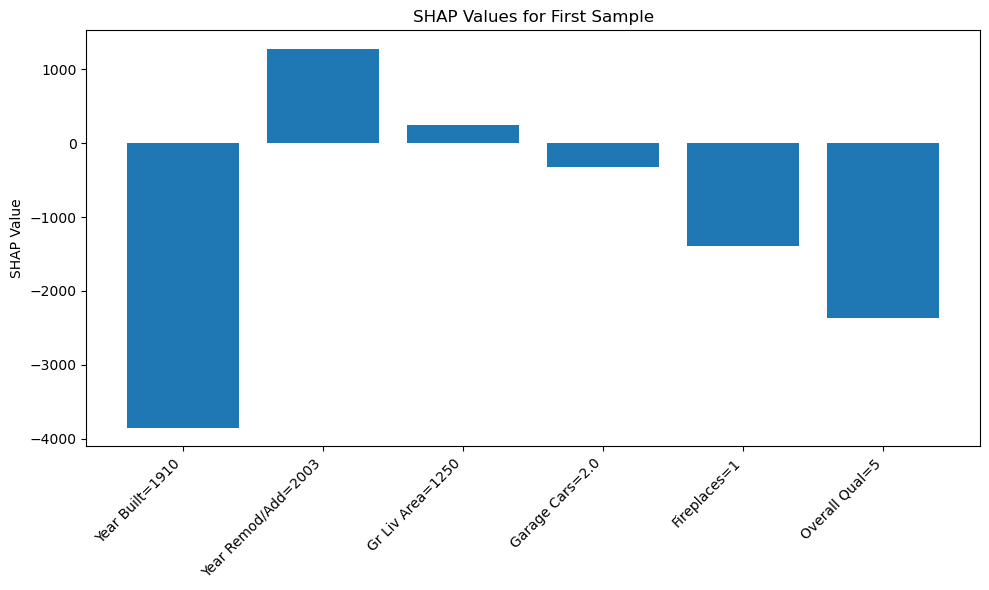

In [85]:
import matplotlib.pyplot as plt

# Convert dictionary to lists for plotting
i = 10
features = [k + "=" + str(explain_X.loc[i, k]) for k in list(shap_values[i].keys())]
values = list(shap_values[i].values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, values)
plt.xticks(rotation=45, ha='right')
plt.title('SHAP Values for First Sample')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()

In [82]:
def info_val_model(X, base_signal):
    y_prob = model1.predict(X)
    return np.array([all_info_model1.instanse_complement_info_value(explanation_feature, base_signal, "AI1", p) for p in y_prob])

feature_names_ordered_for_plot = list(set(selected_features))

explain_X = test[feature_names_ordered_for_plot]
i_shap_values = []
for i in tqdm(range(len(explain_X)), desc="Calculating information SHAP values"):
    stored_predictions = {}
    i_shap_values.append(calc_shap_values(partial(info_val_model, 
                                        base_signal = list(explain_X.loc[i, explanation_feature].values)
                                        ), 
                                        explain_X.loc[i, :], data_grid,
                                        depth = 0))
i_shap_values

Calculating information SHAP values: 100%|██████████| 733/733 [00:39<00:00, 18.46it/s]


[{'Year Remod/Add': 0.0,
  'Garage Cars': 57358615.84973065,
  'Gr Liv Area': 0.0,
  'Fireplaces': 71698269.81216335,
  'Overall Qual': 28849494.79895878,
  'Year Built': 2867930.7924866676},
 {'Year Remod/Add': -209873.55381568274,
  'Garage Cars': -839494.2152631283,
  'Gr Liv Area': 0.0,
  'Fireplaces': -1049367.7690788906,
  'Overall Qual': 5075876.554443359,
  'Year Built': -167898.84305254617},
 {'Year Remod/Add': -122774093.5404613,
  'Garage Cars': 180980488.5527644,
  'Gr Liv Area': -44917351.29529071,
  'Fireplaces': -37431126.07940892,
  'Overall Qual': 105314763.13153419,
  'Year Built': 10677377.807974696},
 {'Year Remod/Add': -413444094.8393575,
  'Garage Cars': -375747428.69342947,
  'Gr Liv Area': -157502512.31975523,
  'Fireplaces': 369694975.20915,
  'Overall Qual': -188921294.78033686,
  'Year Built': -315005024.63951045},
 {'Year Remod/Add': -130996352.62978911,
  'Garage Cars': 215267242.4065078,
  'Gr Liv Area': -3.9736429850260414e-08,
  'Fireplaces': -71193669.9

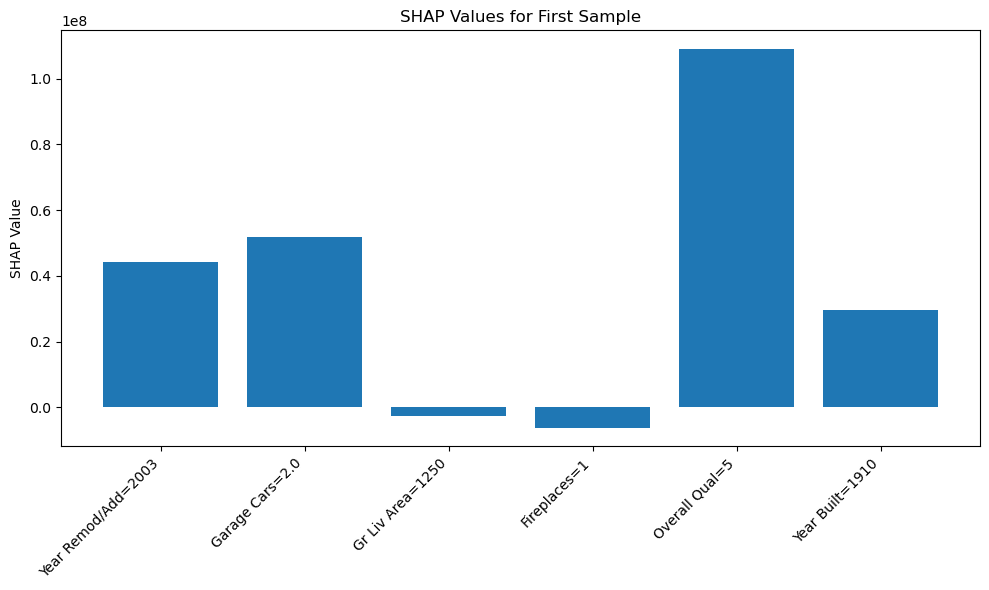

In [86]:
i = 10
features = [k + "=" + str(explain_X.loc[i, k]) for k in list(i_shap_values[i].keys())]
values = list(i_shap_values[i].values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, values)
plt.xticks(rotation=45, ha='right')
plt.title('SHAP Values for First Sample')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()